# AgriVision:  Capstone Project

## Unlock the future of sustainable farming by harnessing deep learning to classify agricultural and non-agricultural lands from satellite images

### Project Pipeline:

- Data Collection: Gathering satellite images and its respective mask that classify agricultural and non-agricultural lands

- Data Preprocessing: Cleaning the images and its respective mask and preparing it for segmentation

- Segmentation: Using SLIC method from the skimage library to segment the satellite images

- Graph Construction and Feature Extraction: Convert the segments to a graph structured data while applying feature extraction from ResNet50 model

- Building the GNN Model: Creating a custom GraphSage architecture from pytorch-geometric library

- Training: Start training the model using BCELoss for binary classification

- Evaluation: Observe the performance of the model using sklearn library

- Deployment: Save the model for deployment once everything is fixed

### Importing Necessary Libraries

In [1]:
import matplotlib.pyplot as plt
import colorsys
from skimage import io
from skimage import color
from skimage import segmentation
from PIL import Image
import imageio
import cv2
import numpy as np
import os
from skimage.util import img_as_float, img_as_int,img_as_bool
from skimage.segmentation import mark_boundaries
from skimage.segmentation import find_boundaries, join_segmentations
from skimage import data, segmentation, color, filters, io, graph, measure
from skimage.measure import regionprops,label
from keras.applications.resnet import preprocess_input #ResNet50
import networkx as nx
from torchvision import transforms
from keras.applications import ResNet50
import torchvision.models as models
from tqdm import tqdm

### Load the Satellite Images and Masks

There are two ways to load the data:

- Google Drive

- Local Directory

In [2]:
# Local Directory
cd = os.getcwd()
print(cd)

/kaggle/working


In [3]:
new_mask_path = '/kaggle/input/capstone/mask_img-20250108T122341Z-001/mask_img'
new_sat_path = '/kaggle/input/capstone/Sat Folder-20250108T123123Z-001/Sat Folder'

In [4]:
# This series of blocks of code is dedicated to looking for the individual files within the single folder and create new folders for their respective types

#initialize lists to separate masks and sat images
mask = list()
sat = list()
newmask = "Mask folder"
newsat = "Sat folder"

#create loop for separation
# for i in os.listdir(cd):
#     if os.path.isfile(os.path.join(cd, i)) and i.endswith(".png") or i.endswith(".jpg"):
#         if "mask" in i:
#             mask.append(i)
#         if "sat" in i:
#             sat.append(i)

#new_mask_path = os.path.join(cd,newmask)
#new_sat_path = os.path.join(cd,newsat)

In [5]:
#Accessing the file path of each satellite images and its mask

masks1 = []
for file in os.listdir(new_mask_path):
    if '.ipynb_checkpoints' in file:
        continue
    masks1.append(file)
    
sat1 = []
for file in os.listdir(new_sat_path):
    if '.ipynb_checkpoints' in file:
        continue
    sat1.append(file)

In [6]:
#Verify the files
masks1.sort()
sat1.sort()
print(len(sat1))
print(len(masks1))
      

803
803


### Data Preprocessing

- Verify each mask and transform it to two binary values representing yellow and cyan for agricultural and non agricultural lands

In [7]:

def cleaning_mask(current_index):
    grey = []
    sliced_mask = masks1[current_index: current_index + 20]
    for i in sliced_mask:
        masks4 = os.path.join(new_mask_path, i)
        masks5 = np.array(Image.open(masks4))
        truemask = np.copy(masks5)
        truemask = cv2.cvtColor(truemask,cv2.COLOR_RGBA2RGB)
        target = [0,255,255]
        yellow = [255,255,0]
        bluemask = np.all(truemask == target, axis = -1)
        truemask[~bluemask] = yellow
        truemask = cv2.cvtColor(truemask, cv2.COLOR_RGB2GRAY)
        a = True
        na = False
        truemask[truemask == 179] =  na #Blue
        truemask[truemask == 226] = a #Yellow
        grey.append(truemask.astype(bool))
    return grey

def convert_img_to_arr(current_index):
    color3 = []
    sliced_sat = sat1[current_index: current_index + 20]
    for j in sliced_sat:
        sat3 = os.path.join(new_sat_path, j)
        sat4 = img_as_float(io.imread(sat3))
        color3.append(sat4)
    return color3

In [8]:
'''cm = cleaning_mask(70)
sd = convert_img_to_arr(70)'''

'cm = cleaning_mask(70)\nsd = convert_img_to_arr(70)'

In [9]:
'''fig,ax = plt.subplots(1,2,figsize = (13,13))
ax[0].imshow(cm[5])
ax[1].imshow(sd[5])'''

'fig,ax = plt.subplots(1,2,figsize = (13,13))\nax[0].imshow(cm[5])\nax[1].imshow(sd[5])'

In [10]:

# # Verify the cleaned dataset
# print(f"Number of masks: {len(masks1)}")
# print(f"Number of satellite images: {len(sat1)}")


# for i in range(3):
#     print("")
#     print(f"Processing index {i}")
#     print(f"color3[{i}] shape: {color3[i].shape}")
#     print(f"grey[{i}] shape: {grey[i].shape}")
#     #print(f"grey1[{i}] shape: {grey1[i].shape}")

#### Visualization of Raw Mask and Cleaned Mask

In [11]:
# dismask = os.path.join(new_mask_path, masks1[5])
# dismaskreal= np.array(Image.open(dismask))
# fig,ax = plt.subplots(1,2,figsize=(10,10))
# ax[0].imshow(dismaskreal)
# ax[1].imshow(~grey[5])

#### Visualizing Segmented Images by SLIC Method

In [12]:
def showimg(x):
    '''
    This method displays the segmented slic images

    x: int

    returns: matplotlib image

    x - is an integer value for indexing and accessing the slic and mask list
    '''
    print(np.unique(final_seg[x]))
    ddr4 = mark_boundaries(color3[x],final_seg[x])
    fig, ax = plt.subplots(1,3,figsize=(13,13))
    ax[0].imshow(ddr4)
    ax[0].contour(grey[x], colors = 'red', linewidths = 1)
    ax[1].imshow(ddr4)
    ax[2].imshow(grey[x])

### Segmentation

- Adjust the number segments depending on the area of each class

In [13]:
# The smaller the area of a class, the lower the number of segments
def count_true_pixels(mask):
  total_pixel = mask.size

  counts = np.bincount(mask.ravel())

  true_percent = (counts[0] / total_pixel)
  false_percent = (counts[1] / total_pixel)

  return [float(false_percent), float(true_percent)]

#### SLIC Segmentation

- Checking first if the mask has exactly one segment or one class because it would cause an error regarding slic segmentation

- Adjusting the number of segments based on the area of the class in a mask to avoid clustered nodes

- The maximum segments would be 50 segments both agricultural and non agricultural lands

- After preparing the correct parameters, we now then perform slic method for every satellite images 

In [14]:
def is_all_false(mask):
    return np.all(mask == 0)

def slic_segmentation(current_index,max_seg, color3, grey):
    segmented_images_a = []
    segmented_images_na = []
    for i in range(0,20):
        #print(f" Current Segmentation A I = {i}")
        if is_all_false(grey[i]):
            #print(f"Creating blank segmentation for all-false mask at index {i}")

            blank_segmentation = np.zeros_like(color3[i][:, :, 0], dtype=int) # Create a blank segmentation 
            segmented_images_a.append(blank_segmentation)
        else:
            number_of_segments = [int(i * max_seg) if i >= 0.10 else 4 for i in count_true_pixels(grey[i])]
            segments = segmentation.slic(color3[i], n_segments=number_of_segments[0], mask=grey[i], compactness=20)
            segmented_images_a.append(segments) 
            
        if is_all_false(~grey[i]):
            #print(f"Creating blank segmentation for all-false mask at index {i}")
            blank_segmentation = np.zeros_like(color3[i][:, :, 0], dtype=int) # Create a blank segmentation 
            segmented_images_na.append(blank_segmentation)
        else:
            number_of_segments = [int(i * max_seg) if i >= 0.10 else 4 for i in count_true_pixels(~grey[i])]
            segments1 = segmentation.slic(color3[i], n_segments=number_of_segments[0], mask=~grey[i], compactness=20) 
            segmented_images_na.append(segments1) 


    return segmented_images_a, segmented_images_na

Combine the two segmented images:

- Segmented Agricultural Lands

- Segmented Non Agricultural Lands

In [15]:
def combine_segmentation(segmented_images_a, segmented_images_na):
    final_seg = []
    for i in range(0,20):
        jg = join_segmentations(segmented_images_a[i],segmented_images_na[i])
        final_seg.append(jg)
    return final_seg

In [16]:
#Verify the combined segmented images
#len(final_seg)

In [17]:
def create_graph(final_seg,img_number, color3, grey, visualization=None):
    '''
    This function creates the graph of the segmentation
    using the skimage library such as skimage.segmentation

    img_number: int
    visualization: bool (default=None)

    returns: graph

    img_number - requires an integer value ranging from 0 to the total number of satellite images to access the global variable
    'color3' which contains satellite images and 'grey' which contains the mask that is properly cleaned which is accessed through indexing

    visualizaton - boolean value for visualization
    '''
    seg_img = final_seg[img_number]
    grey_img = grey[img_number]
    img = color3[img_number]
    edges = find_boundaries(seg_img, mode='inner').astype(np.float64)
    graphs = graph.rag_boundary(seg_img, edges,connectivity=1)

    if visualization:
        mbound = mark_boundaries(img, seg_img)
        mbound1 = color.label2rgb(seg_img, mbound, kind='overlay', image_alpha=1, saturation=1)
        regions = measure.regionprops(seg_img)
        centroids = {region.label: region.centroid for region in regions}

        # Visualization code
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        ax.imshow(mbound1)
        for node, (y, x) in centroids.items():
            ax.text(x, y, str(node), color='red', fontsize=12, ha='center', va='center',
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
        lc = graph.show_rag(seg_img, graphs, mbound, edge_width=1.2, img_cmap="bone", border_color="yellow")

    return graphs


#### Visualizing Segmentation into a Graph Structure

In [18]:
#create_graph(5, visualization=True)

In [19]:
# This fucntion creates the features of each region of a certain segmentation, and these features are then used as node attributes of a graph
def create_fmap(final_seg,img_number,color3):

    '''
    This function performs feature extraction from satellite images based on masks using resnet50 
    and returns extracted features in a dictionary format per region

    img_number: int

    returns: featuremap (dictionary)

    img_number - is used as an index to access the satellite images and masks
    '''

    #define variables needed
    featuremap = {}
    si = final_seg[img_number]
    c = color3[img_number]

    #instantiate regions
    regions = np.unique(si)

    #create looping of regions for isolation
    for i in range(len(regions)):

        #isolate region
        sp = si == i
        sptw = mark_boundaries(c,si)

        #Anything outside the region will be 0 valued
        sptw[~sp] = 0

        #resize the image for feature extraction
        sptw = cv2.resize(sptw,(512,512))
        #rearrange image for resnet50
        sptw = sptw.reshape(1,sptw.shape[0],sptw.shape[1],sptw.shape[2])
        sptw = preprocess_input(sptw)

        #Append feature values
        features = resnetModel.predict(sptw,verbose=0)
        featuremap[f'Region {i + 1}'] = features

    return featuremap

Load the ResNet50 Model for feature extraction

In [20]:
#resnetModel = ResNet50(include_top = False,weights = 'imagenet',input_shape = (512,512,3))

weights = '/kaggle/input/weights-no-top/keras/default/1/resnet50_weights_tf_dim_ordering_tf_kernels_notop (1).h5'

resnetModel = ResNet50(include_top = False,weights = weights,input_shape = (512,512,3))

In [21]:
# I converted the block of code from before into a function that takes in the segmentation of an image, and its graph, which then returns the
# class labels for each region/node of the graph.
def assign_label(final_seg,segmented_images_a,segment, graph, prompt=None):
    '''
    This method assigns a class label to each region of a segmentation based on the mask

    segment: int
    graph: graph
    prompt: bool (default=None)

    returns: graph

    segment - an integer value ranging from 0 to the total number of satellite images
    graph - the graph data structure must be from skimage graph object
    prompt - boolean value to see what class is assigned to that node
    '''



    at_segimg = final_seg[segment]
    at_seg = segmented_images_a[segment]
    samereg = {}

    for i, outer_node in enumerate(np.unique(at_segimg)):
        ttest = at_segimg == outer_node
        match = False

        for d, inner_node in enumerate(np.unique(at_seg)):
            ttrain = at_seg == inner_node
    
            # Compare the two masks
            if np.ma.allequal(ttest, ttrain):
                samereg[f'Final segment region {outer_node}'] = inner_node
                graph.nodes[outer_node]['class'] = "Agriculture"
                
                if prompt:
                    print("Class 'Agriculture' added.")
                    print(f"Final seg region {outer_node} is equal to agri segment region {inner_node}")
                
                match = True
                break  # Stop inner loop once a match is found
    
        if not match:
            graph.nodes[outer_node]['class'] = "Not Agriculture"
            
            if prompt:
                print(f"Class 'Not Agriculture' added for region {outer_node}.")


##### Pooling the extracted features


This part is important due to the dimension of the extracted features from resnet50 as it require 1 dimension of the number of features.


- Global Avg Pooling instead of torch.view or torch.reshape method to retain the valuable information

In [22]:
# Using pooling layer to reduce the dimensionality instead of generic reshape method

def apply_gmp(featuremap):
    """
    Applies Global Max Pooling (GMP) to a feature map tensor. This also serves as 
    dimensionality reduction for the feature map

    Args:
        features (torch.Tensor): Input tensor of shape (B, C, H, W).

    Returns:
        torch.Tensor: Pooled feature tensor of shape (B, C).


    Note that this function converts the features to tensor, no need to convert it to tensor beforehand.
    """
    pooled_extracted_features = []
    for features in featuremap:
      features = torch.tensor(featuremap[features], dtype=torch.float)
      gmp = torch.nn.AdaptiveMaxPool2d((1, 1))  # Create GMP layer
      pooled_features = gmp(features).squeeze(-1).squeeze(-1)
      #print(pooled_features.shape)  # Remove H and W dimensions
      #avg_features = torch.mean(features, dim=1)
      #pooled_features = [torch.mean(i[0]) for i in pooled_features]

      #avg = torch.sum(pooled_features, dim=0, keepdim=True)

      pooled_extracted_features.append(pooled_features[0])

      '''
      features = torch.tensor(featuremap[features], dtype=torch.float)
      features = features.permute(0, 3, 1, 2)
      gmp = torch.nn.AdaptiveAvgPool2d(1)  # Create GMP layer
      pooled_features = gmp(features).squeeze(-1).squeeze(-1)

      pooled_extracted_features.append(pooled_features[0])
      '''

    return pooled_extracted_features

def add_fmap(graph, features):
    '''
    This method Assigns the features to the nodes of the graph

    graph: graph
    features: featuremap (dictionary)
    '''
    # Adding the features with respect to its node
    #for node in graph.nodes:
    #    graph.nodes[node]['Features'] = features[node-1]

    for i, node in enumerate(graph.nodes):
        graph.nodes[node]['Features'] = features[i]

In [23]:
#!pip install torch_geometric
!pip install /kaggle/input/torch-geometric/torch_geometric-2.6.1-py3-none-any.whl

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Processing /kaggle/input/torch-geometric/torch_geometric-2.6.1-py3-none-any.whl


### Building the GraphSAGE Model

#### Why GraphSAGE?

GraphSAGE (Graph Sample and Aggregation) is a powerful model for learning on graph-structured data, offering advantages such as inductive learning, efficient computation, scalability, and flexibility. It generalizes to unseen nodes and graphs, efficiently computes node embeddings, handles large-scale graphs, and can be combined with various pooling methods and architectures. GraphSAGE has practical applications in tasks like link prediction and node classification, making it a versatile tool for graph representation learning and addressing many challenges in traditional machine learning methods.

In [24]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch.nn import Linear
from torch_geometric.data import Data, Dataset
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import DataLoader
import torch.optim as optim

### GraphSAGE Model Architecture

- Consist of 7 layers of SAGEConv with parameters of bias and aggr by mean

- Default reset_parameters for every layer

- Accepts data object which has two important variables the x and edge_index

- Activation function of ReLU, for the last layer is Sigmoid

In [25]:
from torch_geometric.nn.norm import GraphNorm  # Assuming DGN is implemented as GraphNorm
from torch_geometric.nn.aggr import MultiAggregation, MaxAggregation, PowerMeanAggregation, MulAggregation

class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels=128):
        super().__init__()
        
        # Define the multi-aggregation mechanism
        aggr = MultiAggregation([
            MulAggregation(),
            #PowerMeanAggregation(learn=True),
            MaxAggregation()  # Sum aggregation
            
        ])
        
        # Define the convolutional layers
        self.conv1 = SAGEConv(16, hidden_channels, aggr='max', bias=True)  # First layer with max aggregation
        self.conv2 = SAGEConv(hidden_channels, hidden_channels, aggr=aggr, bias=True)  # Second layer
        self.conv3 = SAGEConv(hidden_channels, hidden_channels, aggr=aggr, bias=True)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels, aggr=aggr, bias=True)
        self.conv5 = SAGEConv(hidden_channels, 1, aggr='mean', normalize=True) 
        
        # GraphNorm layers for normalization
        self.norm1 = GraphNorm(hidden_channels)  # Normalization after the first conv layer
        self.norm2 = GraphNorm(hidden_channels)  # Normalization after the second conv layer
        self.norm3 = GraphNorm(hidden_channels)  # Normalization after the third conv layer
        self.norm4 = GraphNorm(hidden_channels)

        # Dropout for regularization
        self.dropout = torch.nn.Dropout(p=0.5)

    def reset_parameters(self):
        # Reset parameters for all layers
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.conv3.reset_parameters()
        self.conv4.reset_parameters()
        self.conv5.reset_parameters()
        self.norm1.reset_parameters()
        self.norm2.reset_parameters()
        self.norm3.reset_parameters()
        self.norm4.reset_parameters()

    def forward(self, data):
        # Extract features and edge information from the graph data
        x, edge_index = data.x, data.edge_index
        batch = getattr(data, "batch", None)  # Batch info for GraphNorm (used in minibatches)

        # First GraphSAGE layer with normalization and dropout
        x = self.conv1(x, edge_index)
        x = self.norm1(x, batch=batch)
        x = F.relu(x)
        x = self.dropout(x)

        # Second GraphSAGE layer with normalization and dropout
        x = self.conv2(x, edge_index)
        x = self.norm2(x, batch=batch)
        x = F.relu(x)
        x = self.dropout(x)

        # Third GraphSAGE layer with normalization and dropout
        x = self.conv3(x, edge_index)
        x = self.norm3(x, batch=batch)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index)
        x = self.norm4(x, batch=batch)
        x = F.relu(x)
        x = self.dropout(x)

        # Final GraphSAGE layer (no activation or normalization for logits)
        x = self.conv5(x, edge_index)

        return x


In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#### Preparing the Custom Dataset

##### In preparing the Custom Dataset: Lets explore the structure required for GraphSAGE Model

GraphSAGE Layer:

![Input and output shape](/work/input_shape.JPG)

- V: Vertices also known as node
- F: Features of the node

The shape of the input must be (V, F) where V is the number of nodes and F as the number of features

Example: Data with 22 nodes and for each node, there are 7 features

GraphSAGE((22, 7))

In [27]:
#indices of all images splitted for training and testing data
def sample_graph(final_seg,train_range, color3, grey):

    #Note that this data is empy
    train_graph = [create_graph(final_seg,i,color3, grey) for i in range(train_range)]

    indices = [i for i in range(train_range)]
    return indices, train_graph

In [28]:
#Perform the feature extraction and assigning attributes to the graph


In [29]:
def feature_xtract_and_label_assign(final_seg,segmented_images_a,indices, graphs,color3):
    '''
    This method performs all preprocessing excluding graph creation, it feature extract
    satellite images and assign the features to the nodes of the graph also the class label for each node
    but before assigning it, it performs pooling method to reduce the dimensionality of the features
    while retaining valuable information for the model to accept the dataset.
    
    index_type: list
    graphs: list

    returns: None

    index_type - list of indices of the training or testing set
    graphs - list of graphs of the training or testing set

    '''
    for i in tqdm(range(len(indices)), leave=False, desc='feature extract and labeling class'):
        feature = create_fmap(final_seg,indices[i], color3)
        feature = apply_gmp(feature)
        assign_label(final_seg,segmented_images_a,indices[i], graphs[i])
        add_fmap(graphs[i], feature)

#### Custom Graph Dataset Creation

It is important to note that the model accepts data as a torch geometric Data object

Data Object must have:

- x = number of features

- edge_index = edges of the graph in an edge_index format

- y = the node class or node label good for model evaluation

In [30]:


class CustomGraphDataset(Dataset):
  def __init__(self, graphs):
    super(CustomGraphDataset, self).__init__(graphs)
    self.data_list = self.load_and_transform(graphs)

  def load_and_transform(self, graphs):    
    transformed_graph_list = []
    encoder = LabelEncoder()

    for graph_idx, graph in enumerate(graphs):
        node_features = []
        node_classes = []
        
        for node, attributes in graph.nodes(data=True):
            node_features.append(graph.nodes[node]['Features'])
            node_classes.append(graph.nodes[node]['class'])

        node_classes = encoder.fit_transform(node_classes)

        edges = np.array(list(graph.edges))  # Extract edges as a numpy array  
        num_nodes = len(graph.nodes)

        # Log information about the graph
        print(f"Number of nodes: {num_nodes}")

        # Validate edge indices
        '''if edges.max() > num_nodes or edges.min() < 1:
            print(f"Skipping graph {graph_idx + 1} due to invalid edge indices.")
            continue  # Skip this graph and move to the next one'''

        # Convert to zero-based indexing
        #edges -= 1

        # Filter out-of-bounds edges (if necessary)
        edges = edges[(edges[:, 0] < num_nodes) & (edges[:, 1] < num_nodes)]

        # Convert attributes to torch tensor
        node_tensor = torch.tensor(np.array(node_features), dtype=torch.float)      
        edge_index = edges.T  # Transpose to get correct format [2, num_edges]
        edge_index = torch.tensor(edge_index, dtype=torch.long)

        y = torch.tensor(node_classes, dtype=torch.float)

        # Create the Data object
        data = Data(x=node_tensor, edge_index=edge_index, y=y)

        transformed_graph_list.append(data)

    return transformed_graph_list


  def len(self):
    return len(self.data_list)

  def get(self, idx):
    return self.data_list[idx]


#### Flow of transforming Graph Data to Data Object

1. Extract the attributes of the graph data, node features, edge_index, and node classes
2. For node labels, perform LabelEncoder to transform categorical labels to numerical
3. Convert the attributes to tensor Object
4. Create the Data Object where parameters are x, edge_index, and y
    - x : node features
    - edge_index: edge_index
    - y: node labels (Numerical)
5. Append it into the graph list
6. Repeat until all of the graphs are transformed

In [31]:
# Initialize the Custom Dataset


In [32]:
# Create the DataLoader with Batch Size of 12



#### Call the GraphSAGE Model

Note that the parameter requires any data object where it has x and edge_index attribute, it is only passed as a reference for the model so the model would know what the default structure of the data. To know the number of features required for the first input channel of GraphSAGE layer.

- The model requires a data object: train_data.data_list[0] accesses a single data object

- We will be using BCELoss

- The Optimizer is Adam with learning rate or 0.0001

In [33]:
# Initialize the GraphSageModel
model = GraphSAGE()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Create the transform variable

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training the Model

In [34]:
def train_model(model, train_loader, epochs, patience):
    training_losses =[]
    best_loss = float('inf')
    stagnant_epochs = 0
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()

            out = model(batch)
            out = out.squeeze()
            loss = criterion(out, batch.y)

            loss.backward()

            optimizer.step()

            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)

        # Print the average loss for this epoch
        if epoch %1 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}')
            training_losses.append(avg_loss)


        # Check for improvement
        if avg_loss >= best_loss:
            stagnant_epochs += 1
        else:
            best_loss = avg_loss
            stagnant_epochs = 0

        # Early stopping condition
        #if stagnant_epochs >= patience:
            #print(f"Early stopping at epoch {epoch+1}")
            #break
    return training_losses

### Evaluation

In [35]:
def eval_model(model, test_loader):
    
    model.eval()
    correct = 0
    total = 0
    batch_loss = 0
    batch_count = 0

    with torch.no_grad():
        for batch in test_loader:
            
            batch.to(device)
            # Assuming batch contains both data and labels
            # Split the batch into data and labels
            out = model(batch)

            out = out.squeeze(1)

            loss = criterion(out, batch.y)  # Convert batch.y to float for BCEWithLogitsLoss
            batch_loss += loss.item()
            batch_count += 1
            # Ensure pred and y are the same shape
            pred = (out > 0.5).long()
            #print(f"Prediction: {pred}")
            #print(f"Actual: {batch.y}")
            
            # Compare predictions with true labels
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)

    accuracy = (correct / total) * 100
    print(f'Accuracy: {accuracy:.4f}, correct: {correct}, total: {total}')
    return accuracy, batch_loss/batch_count


In [36]:
def pixel_based_segment(model, final_seg, test_data):
    """
    Perform pixel-based segmentation prediction using a model and SLIC segmentation.

    Args:
        model: PyTorch model for prediction.
        final_seg: Superpixel segmentation map (e.g., SLIC output).
        test_data: Input data for prediction (tensor).

    Returns:
        output_image: Segmented output as a mask.
    """

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        # Ensure input data is on the correct device
        data = test_data.to(device)
        
        # Perform model inference
        out = model(data)
        out = out.squeeze(1)  # Remove channel dimension (assumes binary classification)

        # Binarize the predictions (threshold > 0.5 as class 1)
        pred = (out > 0.5).long()

    # Initialize an output image of the same shape as final_seg
    output_image = np.zeros_like(final_seg, dtype=np.uint8)
    
    # Efficient vectorized mapping of predictions to superpixels
    unique_segments = np.unique(final_seg)
    
    # Map predictions to segments
    for segment_id in tqdm(unique_segments, desc="Creating prediction mask", leave=False):
        mask = final_seg == segment_id
        prediction = pred[segment_id - 1] if 0 <= (segment_id - 1) < len(pred) else 0
        output_image[mask] = prediction

    return output_image

In [37]:
def perform_pipeline(current_index, train_range):

    #Data preprocessing
    grey = cleaning_mask(current_index)
    color3 = convert_img_to_arr(current_index)
    #Segmentation
    print(" Beginning Segmentation! ")
    segmented_images_a, segmented_images_na = slic_segmentation(current_index,50,color3, grey)
    final_seg = combine_segmentation(segmented_images_a, segmented_images_na)
    print(" Final Segmentation Finished!")
    print("")
    print(" Beginning sample graph! ")

    indices,graphs = sample_graph(final_seg,train_range, color3, grey)
    print(" Finished Sample graph!")
    print("")
    print(" Beginning Feature extract! " )

    feature_xtract_and_label_assign(final_seg,segmented_images_a,indices, graphs,color3)
    print(" Feature extract finished! ")
    print(" Creating Custom graph! ")

    
    train_data = CustomGraphDataset(graphs)

    del final_seg, color3, grey, segmented_images_a, segmented_images_na, indices


    print(" Dividing them into batches! ")
    
    train_loader = DataLoader(train_data, batch_size=5, shuffle=True)

    print(" Beginning training! ")
    training_losses = train_model(model, train_loader,40, 4)
    print(" Training finished! ")

    #acc = eval_model(model, test_loader)
    current_index += 20
    
    del  graphs, train_data, train_loader

    print('Batches of images finished ')
    print('----------------------------------------------------------------------------------------')

    return current_index, training_losses

In [38]:
current_index = 0
training_losses = []

for i in tqdm(range(0,100,20), desc='training pipeline'):
    print(f"batch number | {int(i/20)}")
    print(f"Current Index is {current_index}")
    curr_idx, losses = perform_pipeline(current_index, 20)
    current_index = curr_idx
    training_losses += losses


training pipeline:   0%|          | 0/5 [00:00<?, ?it/s]

batch number | 0
Current Index is 0
 Beginning Segmentation! 
 Final Segmentation Finished!

 Beginning sample graph! 
 Finished Sample graph!

 Beginning Feature extract! 



feature extract and labeling class: 100%|██████████| 20/20 [24:31<00:00, 72.83s/it]
                                                                                   /usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


 Feature extract finished! 
 Creating Custom graph! 
Number of nodes: 50
Number of nodes: 52
Number of nodes: 49
Number of nodes: 51
Number of nodes: 47
Number of nodes: 53
Number of nodes: 48
Number of nodes: 49
Number of nodes: 49
Number of nodes: 42
Number of nodes: 48
Number of nodes: 48
Number of nodes: 45
Number of nodes: 49
Number of nodes: 49
Number of nodes: 45
Number of nodes: 50
Number of nodes: 44
Number of nodes: 50
Number of nodes: 48
 Dividing them into batches! 
 Beginning training! 
Epoch 1/40, Loss: 0.7853
Epoch 2/40, Loss: 0.8098
Epoch 3/40, Loss: 0.8324
Epoch 4/40, Loss: 0.8369
Epoch 5/40, Loss: 0.8805
Epoch 6/40, Loss: 0.8583
Epoch 7/40, Loss: 0.8422
Epoch 8/40, Loss: 0.8542
Epoch 9/40, Loss: 0.8739
Epoch 10/40, Loss: 0.8789
Epoch 11/40, Loss: 0.8539
Epoch 12/40, Loss: 0.8886
Epoch 13/40, Loss: 0.8778
Epoch 14/40, Loss: 0.8643
Epoch 15/40, Loss: 0.8893
Epoch 16/40, Loss: 0.8903
Epoch 17/40, Loss: 0.9215
Epoch 18/40, Loss: 0.9038
Epoch 19/40, Loss: 0.9192
Epoch 20/4

training pipeline:  20%|██        | 1/5 [30:26<2:01:46, 1826.55s/it]

Epoch 39/40, Loss: 0.9202
Epoch 40/40, Loss: 0.8925
 Training finished! 
Batches of images finished 
----------------------------------------------------------------------------------------
batch number | 1
Current Index is 20
 Beginning Segmentation! 
 Final Segmentation Finished!

 Beginning sample graph! 
 Finished Sample graph!

 Beginning Feature extract! 



feature extract and labeling class: 100%|██████████| 20/20 [25:03<00:00, 73.88s/it]
                                                                                   /usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


 Feature extract finished! 
 Creating Custom graph! 
Number of nodes: 53
Number of nodes: 50
Number of nodes: 47
Number of nodes: 46
Number of nodes: 49
Number of nodes: 52
Number of nodes: 44
Number of nodes: 49
Number of nodes: 48
Number of nodes: 49
Number of nodes: 48
Number of nodes: 49
Number of nodes: 52
Number of nodes: 50
Number of nodes: 48
Number of nodes: 49
Number of nodes: 45
Number of nodes: 49
Number of nodes: 51
Number of nodes: 43
 Dividing them into batches! 
 Beginning training! 
Epoch 1/40, Loss: 1.0187
Epoch 2/40, Loss: 0.9871
Epoch 3/40, Loss: 1.0023
Epoch 4/40, Loss: 0.9912
Epoch 5/40, Loss: 1.0192
Epoch 6/40, Loss: 0.9766
Epoch 7/40, Loss: 1.0101
Epoch 8/40, Loss: 0.9966
Epoch 9/40, Loss: 0.9800
Epoch 10/40, Loss: 0.9797
Epoch 11/40, Loss: 0.9715
Epoch 12/40, Loss: 0.9870
Epoch 13/40, Loss: 0.9852
Epoch 14/40, Loss: 0.9697
Epoch 15/40, Loss: 0.9775
Epoch 16/40, Loss: 0.9896
Epoch 17/40, Loss: 0.9877
Epoch 18/40, Loss: 0.9738
Epoch 19/40, Loss: 0.9372
Epoch 20/4

training pipeline:  40%|████      | 2/5 [1:01:31<1:32:27, 1849.23s/it]

Epoch 40/40, Loss: 0.7454
 Training finished! 
Batches of images finished 
----------------------------------------------------------------------------------------
batch number | 2
Current Index is 40
 Beginning Segmentation! 
 Final Segmentation Finished!

 Beginning sample graph! 
 Finished Sample graph!

 Beginning Feature extract! 



feature extract and labeling class: 100%|██████████| 20/20 [24:55<00:00, 74.97s/it]
                                                                                   /usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


 Feature extract finished! 
 Creating Custom graph! 
Number of nodes: 52
Number of nodes: 44
Number of nodes: 51
Number of nodes: 47
Number of nodes: 48
Number of nodes: 51
Number of nodes: 48
Number of nodes: 48
Number of nodes: 50
Number of nodes: 46
Number of nodes: 46
Number of nodes: 48
Number of nodes: 47
Number of nodes: 47
Number of nodes: 50
Number of nodes: 47
Number of nodes: 46
Number of nodes: 49
Number of nodes: 53
Number of nodes: 50
 Dividing them into batches! 
 Beginning training! 
Epoch 1/40, Loss: 0.7467
Epoch 2/40, Loss: 0.7388
Epoch 3/40, Loss: 0.7514
Epoch 4/40, Loss: 0.7656
Epoch 5/40, Loss: 0.7663
Epoch 6/40, Loss: 0.7521
Epoch 7/40, Loss: 0.7502
Epoch 8/40, Loss: 0.7545
Epoch 9/40, Loss: 0.7721
Epoch 10/40, Loss: 0.7685
Epoch 11/40, Loss: 0.7818
Epoch 12/40, Loss: 0.7822
Epoch 13/40, Loss: 0.7650
Epoch 14/40, Loss: 0.7978
Epoch 15/40, Loss: 0.7676
Epoch 16/40, Loss: 0.7911
Epoch 17/40, Loss: 0.7919
Epoch 18/40, Loss: 0.7618
Epoch 19/40, Loss: 0.7861
Epoch 20/4

training pipeline:  60%|██████    | 3/5 [1:32:22<1:01:39, 1849.76s/it]

Epoch 40/40, Loss: 0.8040
 Training finished! 
Batches of images finished 
----------------------------------------------------------------------------------------
batch number | 3
Current Index is 60
 Beginning Segmentation! 
 Final Segmentation Finished!

 Beginning sample graph! 
 Finished Sample graph!

 Beginning Feature extract! 



feature extract and labeling class: 100%|██████████| 20/20 [23:16<00:00, 62.30s/it]
                                                                                   /usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


 Feature extract finished! 
 Creating Custom graph! 
Number of nodes: 42
Number of nodes: 50
Number of nodes: 49
Number of nodes: 48
Number of nodes: 47
Number of nodes: 49
Number of nodes: 45
Number of nodes: 47
Number of nodes: 46
Number of nodes: 50
Number of nodes: 44
Number of nodes: 50
Number of nodes: 48
Number of nodes: 48
Number of nodes: 53
Number of nodes: 45
Number of nodes: 49
Number of nodes: 49
Number of nodes: 50
Number of nodes: 36
 Dividing them into batches! 
 Beginning training! 
Epoch 1/40, Loss: 0.8164
Epoch 2/40, Loss: 0.8187
Epoch 3/40, Loss: 0.8090
Epoch 4/40, Loss: 0.8000
Epoch 5/40, Loss: 0.8002
Epoch 6/40, Loss: 0.8129
Epoch 7/40, Loss: 0.8274
Epoch 8/40, Loss: 0.8347
Epoch 9/40, Loss: 0.8159
Epoch 10/40, Loss: 0.8403
Epoch 11/40, Loss: 0.8328
Epoch 12/40, Loss: 0.8193
Epoch 13/40, Loss: 0.8166
Epoch 14/40, Loss: 0.8342
Epoch 15/40, Loss: 0.8436
Epoch 16/40, Loss: 0.8292
Epoch 17/40, Loss: 0.8036
Epoch 18/40, Loss: 0.8382
Epoch 19/40, Loss: 0.8426
Epoch 20/4

training pipeline:  80%|████████  | 4/5 [2:01:23<30:06, 1806.85s/it]  

Epoch 40/40, Loss: 0.8371
 Training finished! 
Batches of images finished 
----------------------------------------------------------------------------------------
batch number | 4
Current Index is 80
 Beginning Segmentation! 
 Final Segmentation Finished!

 Beginning sample graph! 
 Finished Sample graph!

 Beginning Feature extract! 



feature extract and labeling class: 100%|██████████| 20/20 [23:10<00:00, 66.19s/it]
                                                                                   /usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


 Feature extract finished! 
 Creating Custom graph! 
Number of nodes: 47
Number of nodes: 48
Number of nodes: 51
Number of nodes: 50
Number of nodes: 52
Number of nodes: 42
Number of nodes: 47
Number of nodes: 46
Number of nodes: 49
Number of nodes: 51
Number of nodes: 51
Number of nodes: 49
Number of nodes: 49
Number of nodes: 49
Number of nodes: 47
Number of nodes: 47
Number of nodes: 46
Number of nodes: 48
Number of nodes: 41
Number of nodes: 42
 Dividing them into batches! 
 Beginning training! 
Epoch 1/40, Loss: 0.8189
Epoch 2/40, Loss: 0.8349
Epoch 3/40, Loss: 0.8252
Epoch 4/40, Loss: 0.8373
Epoch 5/40, Loss: 0.8426
Epoch 6/40, Loss: 0.8179
Epoch 7/40, Loss: 0.8323
Epoch 8/40, Loss: 0.8096
Epoch 9/40, Loss: 0.8139
Epoch 10/40, Loss: 0.8338
Epoch 11/40, Loss: 0.8194
Epoch 12/40, Loss: 0.8226
Epoch 13/40, Loss: 0.8283
Epoch 14/40, Loss: 0.8215
Epoch 15/40, Loss: 0.8230
Epoch 16/40, Loss: 0.8128
Epoch 17/40, Loss: 0.8035
Epoch 18/40, Loss: 0.8156
Epoch 19/40, Loss: 0.8318
Epoch 20/4

training pipeline: 100%|██████████| 5/5 [2:30:26<00:00, 1805.32s/it]

Epoch 40/40, Loss: 0.8581
 Training finished! 
Batches of images finished 
----------------------------------------------------------------------------------------


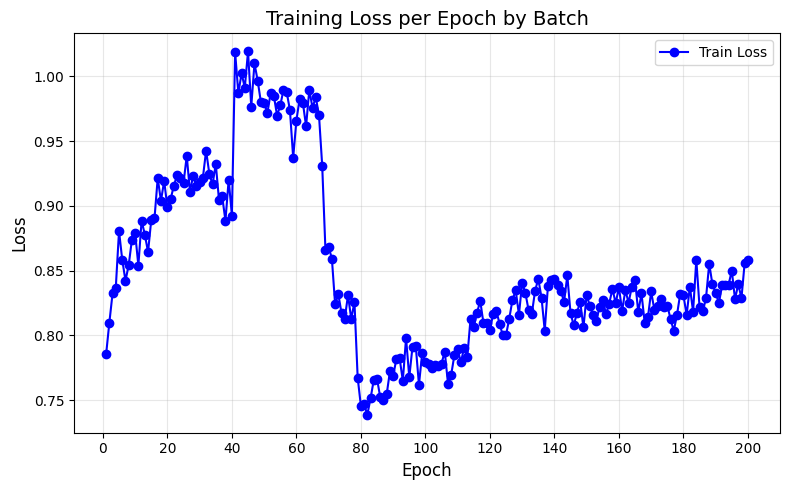

In [39]:
epochs = range(1, len(training_losses) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, training_losses, marker='o', linestyle='-', color='b', label='Train Loss')
plt.title('Training Loss per Epoch by Batch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Set x-axis ticks at every 25 epochs
plt.xticks(range(0, len(training_losses) + 1, 20))

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Model Evaluation

### Pixel Based Evaluation

In [40]:

def evaluation_batch(current_index ,test_range):

    current_segment_scores = [[], [], [], []]
    #Data preprocessing
    grey = cleaning_mask(current_index)
    color3 = convert_img_to_arr(current_index)
    #Segmentation
    segmented_images_a, segmented_images_na = slic_segmentation(current_index,50,color3, grey)
    final_seg = combine_segmentation(segmented_images_a, segmented_images_na)

    #Beginning sample graph!

    indices,graphs = sample_graph(final_seg,test_range, color3, grey)

    #Beginning Feature extract

    feature_xtract_and_label_assign(final_seg,segmented_images_a,indices, graphs,color3)

    #Creating Custom graph!
    
    test_data = CustomGraphDataset(graphs)


    #Dividing them into batches!
    
    test_loader = DataLoader(test_data, batch_size=5, shuffle=True)

    #Beginning training!
    accuracy, test_loss = eval_model(model, test_loader)


    for idx in range(len(grey)):
        #grey_binary = grey[idx].astype(np.uint8)
        prediction_mask = pixel_based_segment(model, final_seg[idx], test_data[idx])
        segment_metrics = compute_weighted_metrics(grey[idx], prediction_mask)

        for i, value in enumerate(segment_metrics):
            current_segment_scores[i].append(value)

        print(idx)

        #print(grey[idx])
    
        #print(prediction_mask)

        fig,ax = plt.subplots(1,3,figsize = (13,13))
        ax[0].imshow(color3[idx])
        ax[0].set_title('sattelite image')
        ax[1].imshow(grey[idx])
        ax[1].set_title('True mask')
        ax[2].imshow(prediction_mask)
        ax[2].set_title('Prediction Segments')
        plt.show()

    current_index += 20
    
    del color3, grey, segmented_images_a, segmented_images_na, indices, graphs, test_data, test_loader, final_seg

    return current_index, accuracy, current_segment_scores, test_loss


In [41]:
from sklearn.metrics import jaccard_score, f1_score, accuracy_score, matthews_corrcoef

# Function to compute weighted metrics
def compute_weighted_metrics(y_true, y_pred):
    """
    Compute weighted IoU, Dice, Accuracy, and MCC based on class pixel distribution.
    
    Parameters:
        y_true (np.array): Ground truth binary mask (0 or 1).
        y_pred (np.array): Predicted binary mask (0 or 1).
    
    Returns:
        dict: Weighted metrics (IoU, Dice, Accuracy, MCC).
    """
    # Flatten arrays
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    # Compute class weights
    total_pixels = len(y_true_flat)
    class_0_weight = np.sum(y_true_flat == 0) / total_pixels  # Background
    class_1_weight = np.sum(y_true_flat == 1) / total_pixels  # Foreground (object)
    
    # Compute metrics for each class
    iou_class_0 = jaccard_score(y_true_flat, y_pred_flat, pos_label=0)
    iou_class_1 = jaccard_score(y_true_flat, y_pred_flat, pos_label=1)
    dice_class_0 = f1_score(y_true_flat, y_pred_flat, pos_label=0)
    dice_class_1 = f1_score(y_true_flat, y_pred_flat, pos_label=1)
    
    # Weighted metrics
    weighted_iou = class_0_weight * iou_class_0 + class_1_weight * iou_class_1
    weighted_dice = class_0_weight * dice_class_0 + class_1_weight * dice_class_1
    
    # Overall metrics
    acc = accuracy_score(y_true_flat, y_pred_flat)
    mcc = matthews_corrcoef(y_true_flat, y_pred_flat)
    
    return weighted_iou, weighted_dice, acc, mcc

feature extract and labeling class: 100%|██████████| 20/20 [25:26<00:00, 77.00s/it]
                                                                                   /usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Number of nodes: 49
Number of nodes: 48
Number of nodes: 50
Number of nodes: 51
Number of nodes: 47
Number of nodes: 47
Number of nodes: 53
Number of nodes: 48
Number of nodes: 51
Number of nodes: 45
Number of nodes: 52
Number of nodes: 46
Number of nodes: 49
Number of nodes: 50
Number of nodes: 52
Number of nodes: 50
Number of nodes: 42
Number of nodes: 48
Number of nodes: 52
Number of nodes: 50
Accuracy: 43.5714, correct: 427, total: 980



Creating prediction mask:  92%|█████████▏| 45/49 [00:00<00:00, 144.58it/s]
                                                                          

0


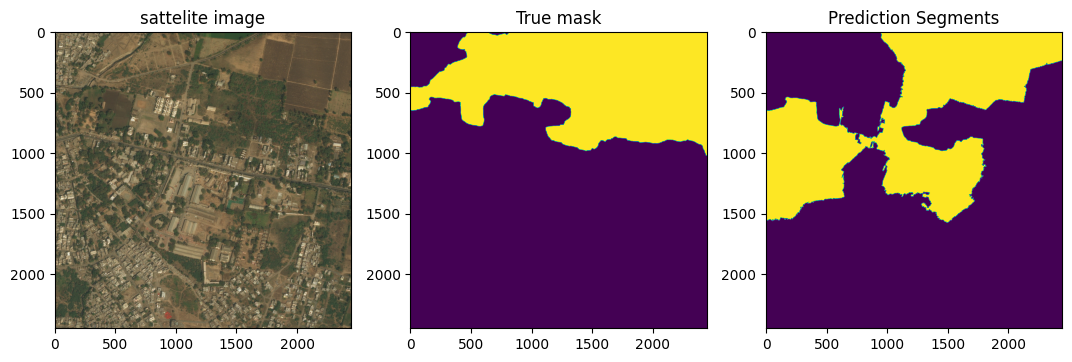


Creating prediction mask:  94%|█████████▍| 45/48 [00:00<00:00, 146.12it/s]
                                                                          

1


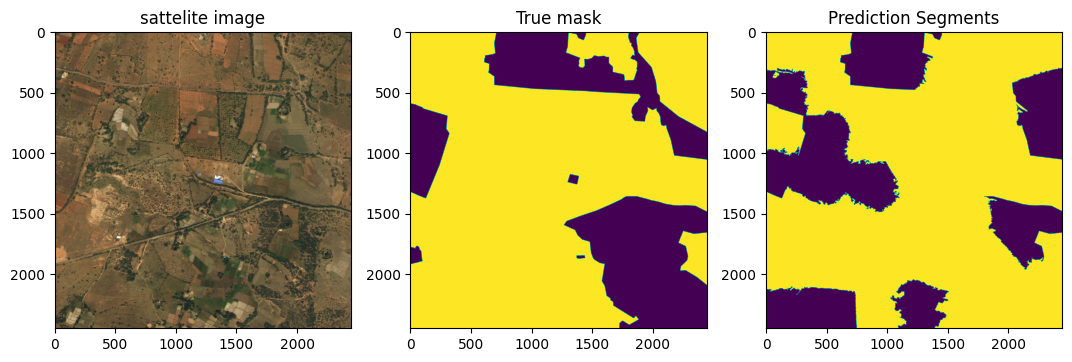


Creating prediction mask:  94%|█████████▍| 47/50 [00:00<00:00, 150.23it/s]
                                                                          

2


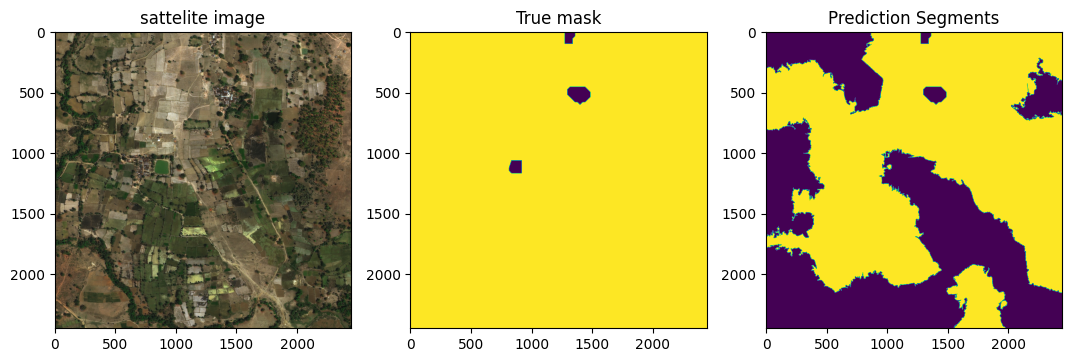


Creating prediction mask:  94%|█████████▍| 48/51 [00:00<00:00, 149.77it/s]
                                                                          

3


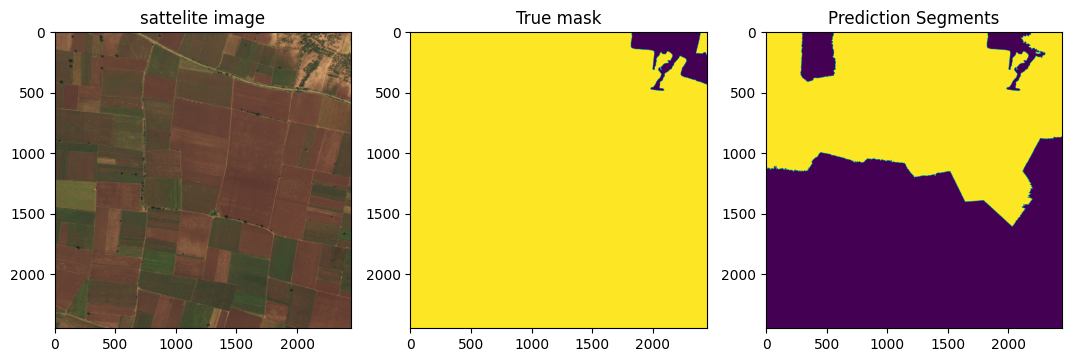


Creating prediction mask:  68%|██████▊   | 32/47 [00:00<00:00, 150.50it/s]
                                                                          

4


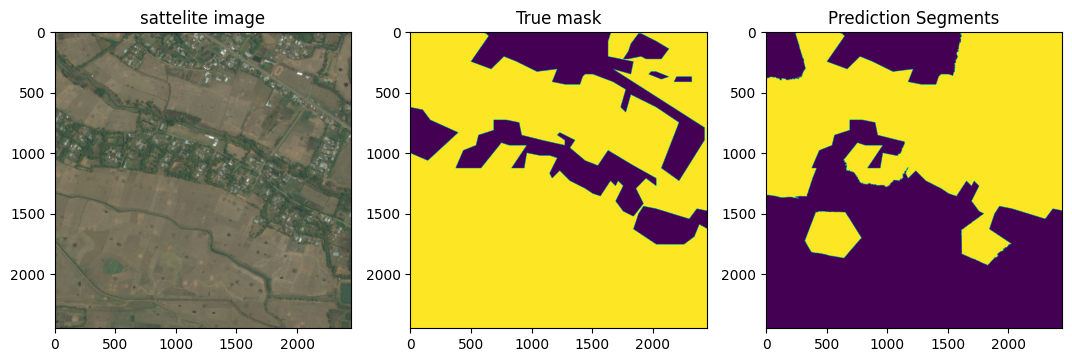


Creating prediction mask:  68%|██████▊   | 32/47 [00:00<00:00, 152.33it/s]
                                                                          

5


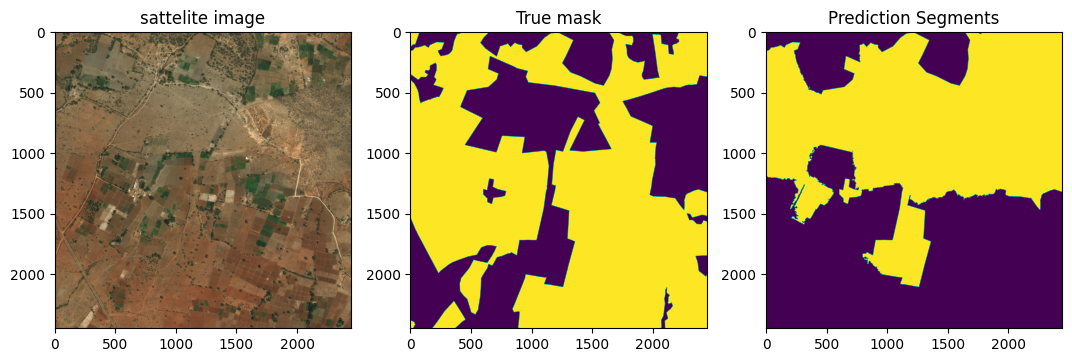


Creating prediction mask:  91%|█████████ | 48/53 [00:00<00:00, 154.12it/s]
                                                                          

6


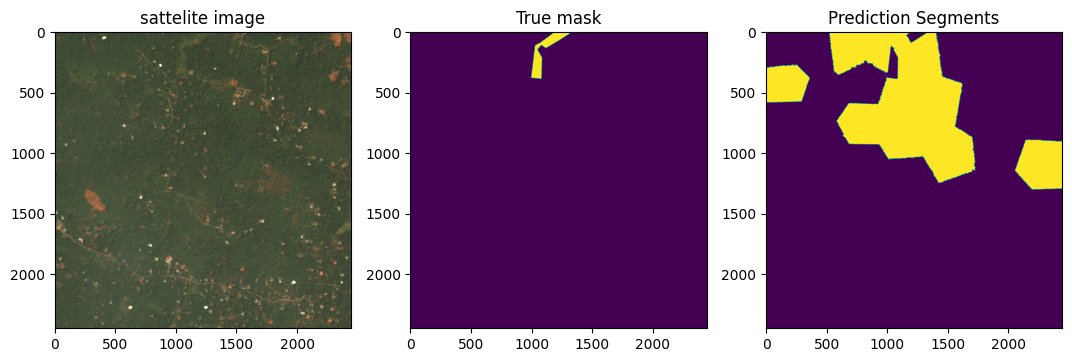


Creating prediction mask: 100%|██████████| 48/48 [00:00<00:00, 147.96it/s]
                                                                          

7


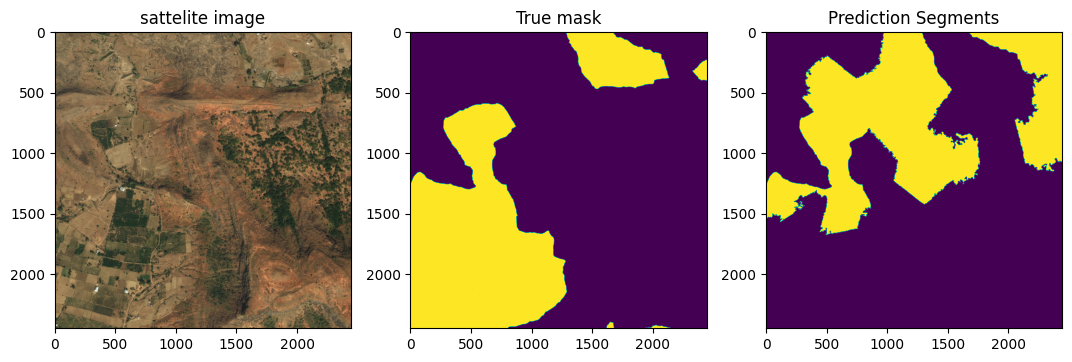


Creating prediction mask:  94%|█████████▍| 48/51 [00:00<00:00, 157.64it/s]
                                                                          

8


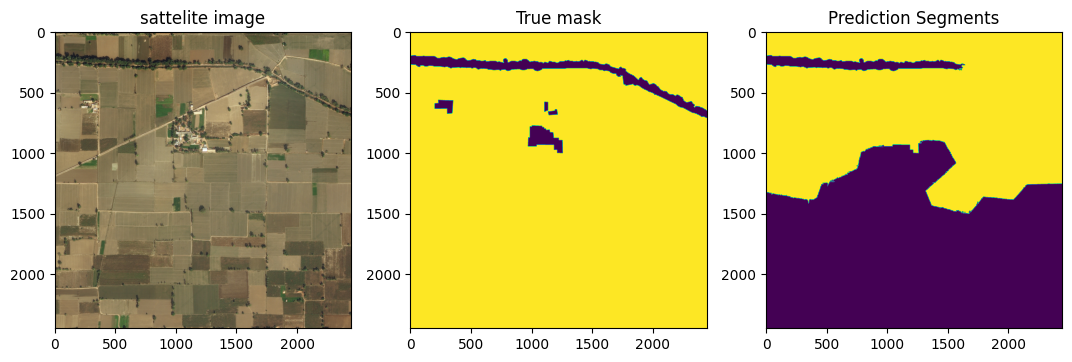


Creating prediction mask:  76%|███████▌  | 34/45 [00:00<00:00, 156.85it/s]
                                                                          

9


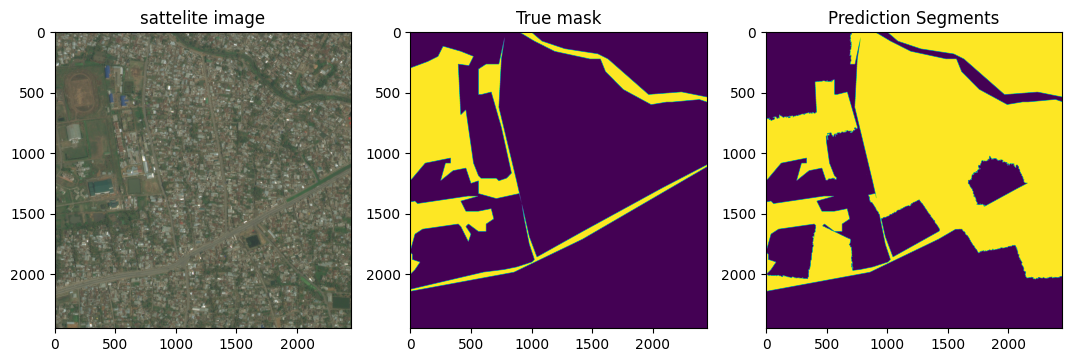


Creating prediction mask:  90%|█████████ | 47/52 [00:00<00:00, 146.20it/s]
                                                                          

10


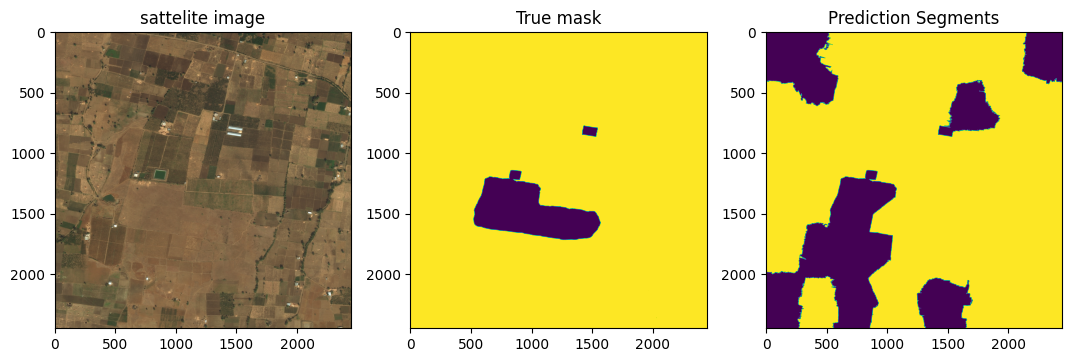


Creating prediction mask:  98%|█████████▊| 45/46 [00:00<00:00, 145.86it/s]
                                                                          

11


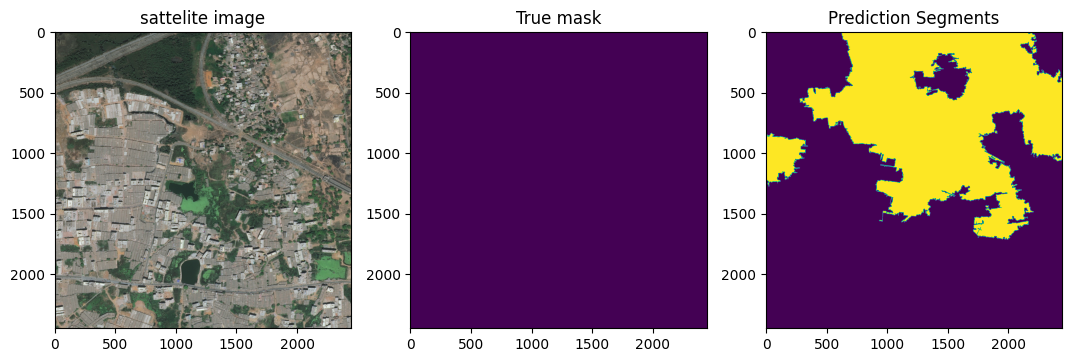


Creating prediction mask:  98%|█████████▊| 48/49 [00:00<00:00, 150.77it/s]
                                                                          

12


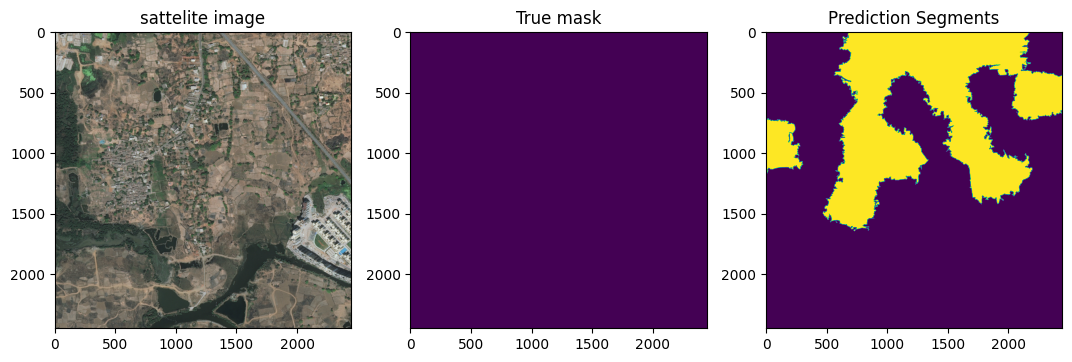


Creating prediction mask:  96%|█████████▌| 48/50 [00:00<00:00, 151.51it/s]
                                                                          

13


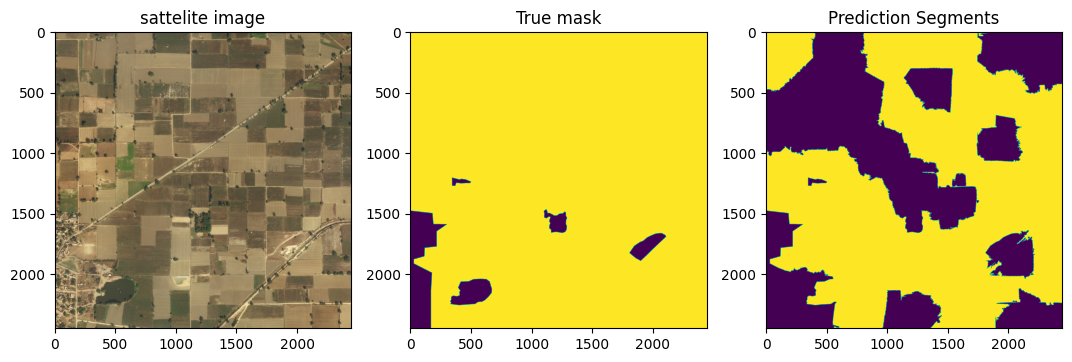


Creating prediction mask:  90%|█████████ | 47/52 [00:00<00:00, 146.84it/s]
                                                                          

14


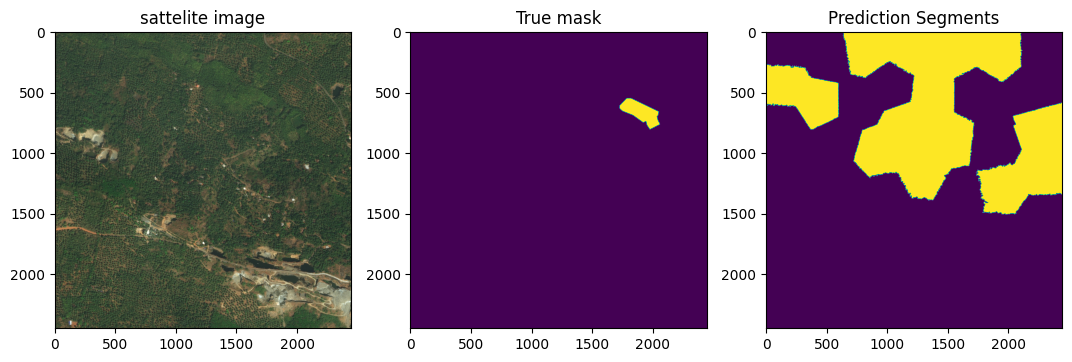


Creating prediction mask:  94%|█████████▍| 47/50 [00:00<00:00, 148.26it/s]
                                                                          

15


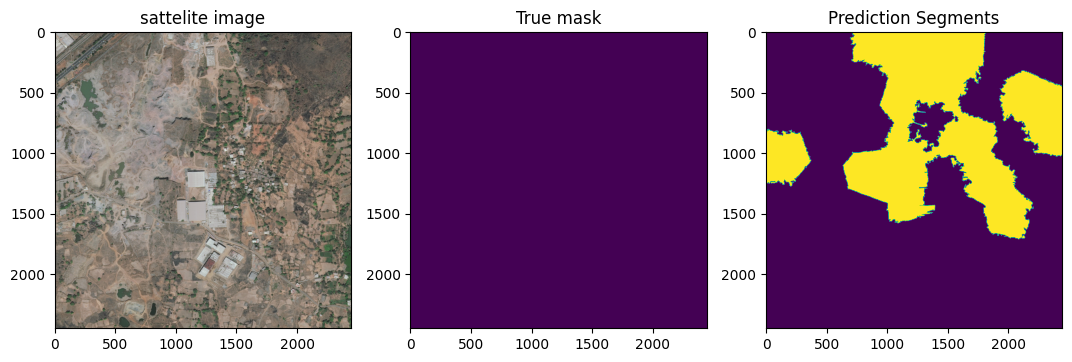


Creating prediction mask:  76%|███████▌  | 32/42 [00:00<00:00, 149.39it/s]
                                                                          

16


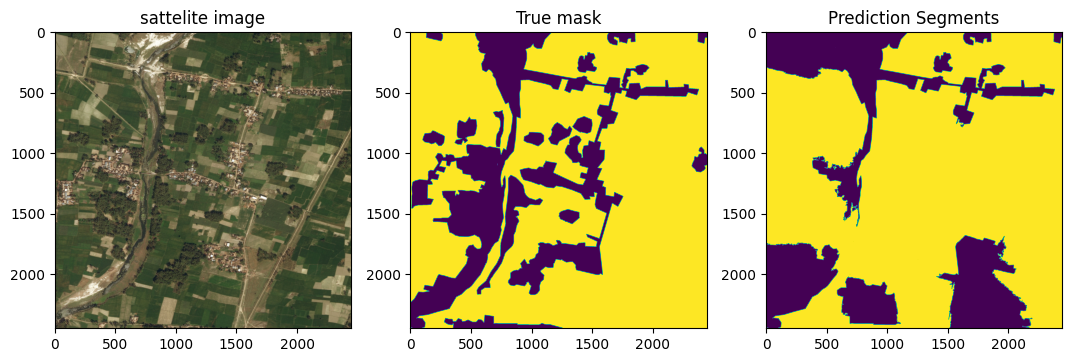


Creating prediction mask: 100%|██████████| 48/48 [00:00<00:00, 151.39it/s]
                                                                          

17


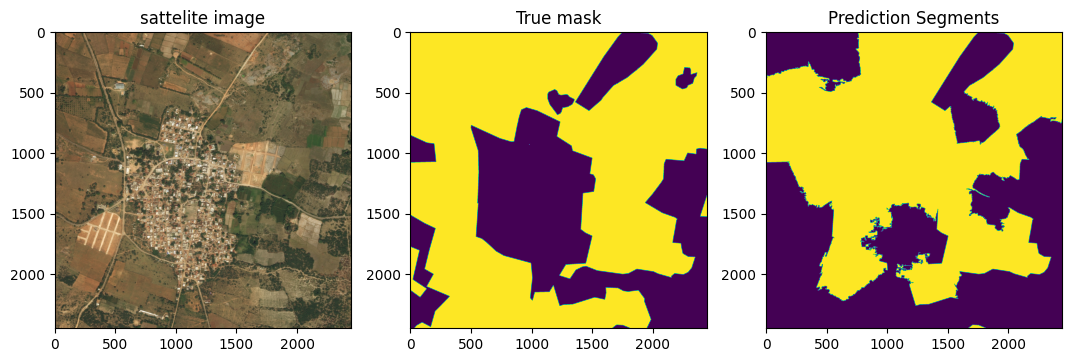


Creating prediction mask:  87%|████████▋ | 45/52 [00:00<00:00, 147.69it/s]
                                                                          

18


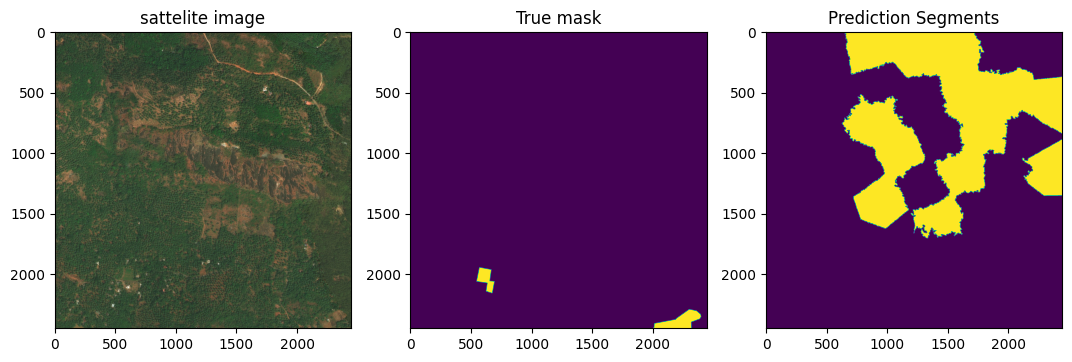


Creating prediction mask:  90%|█████████ | 45/50 [00:00<00:00, 145.77it/s]
                                                                          

19


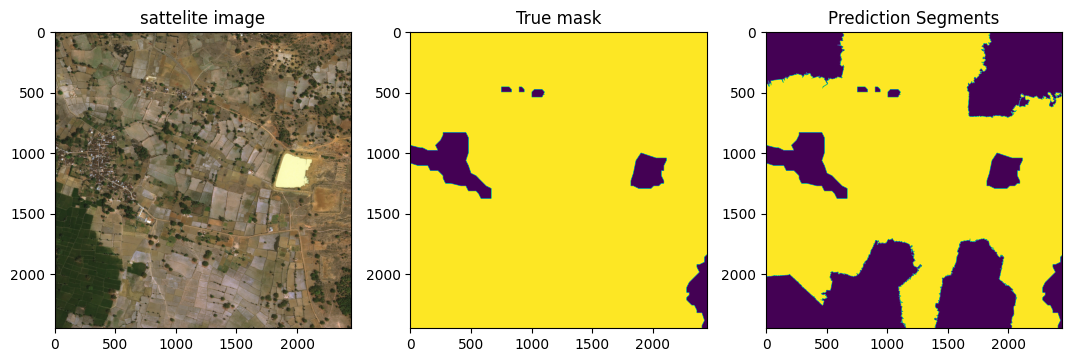

evaluation_pipeline: 100%|██████████| 1/1 [36:15<00:00, 2175.69s/it]


In [42]:
scores = []
test_losses = []
eval_index = 600

batches_num = 0
segmentation_scores = np.array([0, 0, 0, 0], dtype=float)
for i in tqdm(range(600, 620, 20), desc='evaluation_pipeline'):

   
    curr_idx, acc, segment_metrics, test_loss = evaluation_batch(eval_index ,20)
    # Update the scores list by adding the list values
    #for idx, value in enumerate(segment_metrics):
    #    segment_scores[idx].append(value)
    avg_segment_scores = np.array([np.mean(i) for i in segment_metrics])
    
    segmentation_scores += avg_segment_scores
    test_losses.append(test_loss)
    batches_num += 1

    
    
    scores.append(acc)
    eval_index = curr_idx

### Node based Evaluation

In [46]:
print(segmentation_scores)
print(scores)

[0.56441126 0.70156824 0.62736314 0.05398155]
[43.57142857142857]


In [47]:
print(scores)
avg = sum(scores)/len(scores)
print(f'Average Accuracy: {avg}')

all_segmentation_scores = [i/batches_num for i in segmentation_scores]

[43.57142857142857]
Average Accuracy: 43.57142857142857


In [48]:
metrics = ['Weighted IoU', 'Weighted Dice', 'Accuracy', 'MCC']
for metric, score in zip(metrics, all_segmentation_scores):
    print(f"{metric}: {score:.8f}")

Weighted IoU: 0.56441126
Weighted Dice: 0.70156824
Accuracy: 0.62736314
MCC: 0.05398155


In [ ]:
print(test_losses)

In [ ]:
test_batch = range(1, len(test_losses) + 1)

plt.figure(figsize=(8, 5))
plt.plot(test_batch, test_losses, marker='o', linestyle='-', color='b', label='Train Loss')
plt.title('Test Loss by Batch (10 images)', fontsize=14)
plt.xlabel('Batch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Set x-axis ticks at every 25 epochs
plt.xticks(range(0, len(test_losses) + 1, 5))

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
grey = cleaning_mask(0)
color3 = convert_img_to_arr(0)

segmented_images_a, segmented_images_na = slic_segmentation(0,20,color3, grey)
final_seg = combine_segmentation(segmented_images_a, segmented_images_na)
print(" Final Segmentation Finished!")
print("")
print(" Beginning sample graph! ")

indices,graphs = sample_graph(final_seg,15, color3, grey)
print(" Finished Sample graph!")
print("")
print(" Beginning Feature extract! " )

feature_xtract_and_label_assign(final_seg,segmented_images_a,indices, graphs,color3)
print(" Feature extract finished! ")
print(" Creating Custom graph! ")


#del final_seg, color3, grey, segmented_images_a, segmented_images_na, indices

## Test Prediction

In [ ]:
def feature_extract(segment, img):
    featuremap = {}
    si = segment
    c = img

    #instantiate regions
    regions = np.unique(si)

    #create looping of regions for isolation
    for i in range(len(regions)):

        #isolate region
        sp = si == i
        sptw = mark_boundaries(c,si)

        #Anything outside the region will be 0 valued
        sptw[~sp] = 0

        #resize the image for feature extraction
        sptw = cv2.resize(sptw,(512,512))
        #rearrange image for resnet50
        sptw = sptw.reshape(1,sptw.shape[0],sptw.shape[1],sptw.shape[2])
        sptw = preprocess_input(sptw)

        #Append feature values
        features = resnetModel.predict(sptw)
        featuremap[f'Region {i + 1}'] = features

    return featuremap


def segment_image(img_path):
    img = img_as_float(io.imread(img_path))
    segments = segmentation.slic(img, n_segments=50, compactness=20)
    return segments, img

def graph_image(img_path):
    seg, img = segment_image(img_path)
    edges = find_boundaries(seg, mode='inner').astype(np.float64)
    graphs = graph.rag_boundary(seg, edges, connectivity=1)
    pooled_features = apply_gmp(feature_extract(seg, img))
    add_fmap(graphs, pooled_features)

    return graphs

def apply_gmp(featuremap):
    pooled_extracted_features = []
    for features in featuremap:

      features = torch.tensor(featuremap[features], dtype=torch.float)
      gmp = torch.nn.AdaptiveMaxPool2d((1, 1))  # Create GMP layer
      pooled_features = gmp(features).squeeze(-1).squeeze(-1)
      print(pooled_features.shape)  # Remove H and W dimensions
      #avg_features = torch.mean(features, dim=1)
      #pooled_features = [torch.mean(i[0]) for i in pooled_features]

      pooled_extracted_features.append(pooled_features[0])

      '''
      features = torch.tensor(featuremap[features], dtype=torch.float)
      features = features.permute(0, 3, 1, 2)
      gmp = torch.nn.AdaptiveAvgPool2d(1)  # Create GMP layer
      pooled_features = gmp(features).squeeze(-1).squeeze(-1)
      #print(pooled_features.shape)  # Remove H and W dimensions
      #avg_features = torch.mean(features, dim=1)
      #pooled_features = [torch.mean(i[0]) for i in pooled_features]

      #avg = torch.sum(pooled_features, dim=0, keepdim=True)

      pooled_extracted_features.append(pooled_features[0])'''

    return pooled_extracted_features


def add_fmap(graph, features):
    # Adding the features with respect to its node
    for i, node in enumerate(graph.nodes):
        graph.nodes[node]['Features'] = features[i]

In [ ]:
def graph_to_tensor(temp_graph):
    nodes = []
    for node, attributes in temp_graph.nodes(data=True):
        nodes.append(temp_graph.nodes[node]['Features'])

    edges = np.array(list(temp_graph.edges))  # Extract edges as a numpy array
    edge_index = edges.T
    edge_index


    # Node features (4 nodes, 2 features each)
    x = torch.tensor(np.array(nodes), dtype=torch.float)
    #x = x.view(x.shape[0] , -1)

    edge_index = torch.tensor(edge_index, dtype=torch.long)


    #Checking if edge_index matches with the number of nodes
    #if edge_index.max().item() >= x.shape[0]:
    #    raise ValueError(f"Edge index exceeds the number of nodes ({x.shape[0]}). Max index: {edge_index.max().item()}")

    temp_data = Data(x=x, edge_index=edge_index)

    #temp_data = transform(temp_data)
    return temp_data #Return a Data Object

In [ ]:
sig = torch.nn.Sigmoid()


def predict(temp_data):
  model.eval()  # Set the model to evaluation mode
  with torch.no_grad():  # Disable gradient calculations during evaluation
    out =  model(graph_to_tensor(temp_data))
    sigmoid_ = sig(out)
    prediction = (sigmoid_ > 0.5).float()
    return prediction, sigmoid_

In [ ]:


sample_image = '/kaggle/input/capstone/Sat Folder-20250108T123123Z-001/Sat Folder/123172_sat.jpg'

img_samp = graph_image(sample_image)


In [ ]:
for i in img_samp.nodes:
    print(i)

In [ ]:
prediction, sigmoids = predict(img_samp)
prediction = prediction.squeeze()
sigmoid_nums = sigmoids.squeeze().cpu().numpy()

In [ ]:
print(prediction)
print(sigmoids)

### Visualize Prediction

In [ ]:
for node in np.unique(img_samp.nodes):

#for i, node in enumerate(img_samp.nodes):
    img_samp.nodes[node]['class'] = prediction[node-1]


In [ ]:
print(len(img_samp.nodes))

In [ ]:
original_image = img_as_float(io.imread(sample_image))

output_image = np.zeros_like(original_image, dtype=np.uint8)

img_segments = segmentation.slic(original_image, n_segments=30, start_label=1)
for segment_id in np.unique(img_segments):
    mask = img_segments == segment_id
    if img_samp.nodes[segment_id]['class'] == 0:
        output_image[mask] = [0, 255, 255]  # Cyan
    else:
        output_image[mask] = [255, 255, 0]  # Yellow

fig, axes = plt.subplots(1, 2, figsize=(15, 15))

# Original image
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis("off")

# Output image
axes[1].imshow(output_image)
axes[1].set_title('Segmented Image')
axes[1].axis("off")

plt.tight_layout()


In [ ]:
from skimage.color import label2rgb


def visualize_segments(segments, image, sigmoids):
    # Get the image corresponding to img_number
    # Find boundaries for the segments and convert them to float64
    edges = find_boundaries(segments, mode='inner').astype(np.float64)
    
    # Mark the boundaries on the image
    mbound = mark_boundaries(image, segments)
    
    # Create an overlay of the image with the segment boundaries marked
    mbound1 = label2rgb(segments, image=mbound, kind='overlay', image_alpha=1, saturation=1)
    
    # Measure the regions in the segmented image
    regions = measure.regionprops(segments)
    
    # Get the centroids of the regions
    centroids = {region.label: region.centroid for region in regions}
    
    # Plot the image with boundaries and centroids
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(mbound1)
    
    # Add centroids as red text at the respective positions
    for node, (y, x) in centroids.items():
        ax.text(x, y, str(round(sigmoids[node-1], 4)), color='red', fontsize=12, ha='center', va='center',
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    
    # Show the plot
    plt.show()

In [ ]:
print(prediction.squeeze())

In [ ]:
visualize_segments(img_segments, original_image, sigmoid_nums)

In [ ]:
import torch

# Assume `model` is your PyTorch model
torch.save(model.state_dict(), "model_weights_restructured_15imgbatch.pth")


In [ ]:
torch.save(model, "model_10img_batch.pth")